# Markov Chain for Campaign Attribution POC

In [1]:
import mta
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import seaborn as sns
from scipy.stats import pearsonr
# if you haven't alreadya GCP authenticated run !gcloud auth login
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

# data has been saved to the repo, if you want to redownload from GCP, set to True
REDOWNLOAD_FROM_GCP = True

Visit http://www.channelattribution.net for more information about ChannelAttribution


Information about MTA module  
https://bitbucket.org/wx_rds/mta/src/50cd3c3f2469/?at=master  
https://bytebucket.org/wx_rds/mta/wiki/_build/latex/mta.pdf?token=ed3f93f21d7e08c5a92ba0abba35888f63412a54&rev=599fd6872540e9a4945b968e0f02a87c9fc15ea5  
https://www.channelattribution.net/assets/files/ChannelAttributionWhitePaper-0536c269c4725179d4a0d8b8ec2f0fac.pdf

## MC POC data

In [2]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # alternative to reading from GCP directly into pandas dataframe, not working since MTA update
    !rm -f 02_data/MCPOC_input*.csv
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_*.csv 02_data/

Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000000.csv...
Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000001.csv...  
Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000002.csv...  
\ [3 files][357.2 MiB/357.2 MiB]                                                
Operation completed over 3 objects/357.2 MiB.                                    


In [3]:
df = pd.DataFrame()
for f in glob.glob('02_data/MCPOC_input_*.csv'):
    df = df.append(pd.read_csv(f))

In [4]:
df.head()

wk_start_date                                               path  num_crn  \
0    2021-02-08                     CAT-4003_2021-01-28_activation    16549   
1    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...      179   
2    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...       21   
3    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   
4    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   

   inc_sales  conversion_inc_sales_positive  \
0   -44.9073                              0   
1   207.5564                              4   
2  1180.4009                             19   
3   340.6045                              1   
4   141.9836                              1   

   non_conversion_inc_sales_positive  conversion_act_purchase  \
0                              16549                        0   
1                                175                      179   
2                                  2                       21   
3                                  0                        1   
4                                  0                        1   

   non_conversion_act_purchase  
0                        16549  
1                            0  
2                            0  
3                            0  
4                            0

In [5]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # alternative to reading from GCP directly into pandas dataframe
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv 02_data/campaign_info000000000000.csv
    campaign_info = pd.read_csv('02_data/campaign_info000000000000.csv')

Copying gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv...
/ [1 files][  8.1 KiB/  8.1 KiB]                                                
Operation completed over 1 objects/8.1 KiB.                                      


In [6]:
# NA inc sales causes NAN for CA
print("number of NA inc sales", sum(df.inc_sales.isnull()))
df.loc[:, "inc_sales"] = df.loc[:, "inc_sales"].fillna(0)
print("number of NA inc sales after filling in", sum(df.inc_sales.isnull()))

number of NA inc sales 205244
number of NA inc sales after filling in 0


In [7]:
df.head()

wk_start_date                                               path  num_crn  \
0    2021-02-08                     CAT-4003_2021-01-28_activation    16549   
1    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...      179   
2    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...       21   
3    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   
4    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   

   inc_sales  conversion_inc_sales_positive  \
0   -44.9073                              0   
1   207.5564                              4   
2  1180.4009                             19   
3   340.6045                              1   
4   141.9836                              1   

   non_conversion_inc_sales_positive  conversion_act_purchase  \
0                              16549                        0   
1                                175                      179   
2                                  2                       21   
3                                  0                        1   
4                                  0                        1   

   non_conversion_act_purchase  
0                        16549  
1                            0  
2                            0  
3                            0  
4                            0

In [8]:
sum(df.inc_sales)

27125857.72330014

<AxesSubplot:>

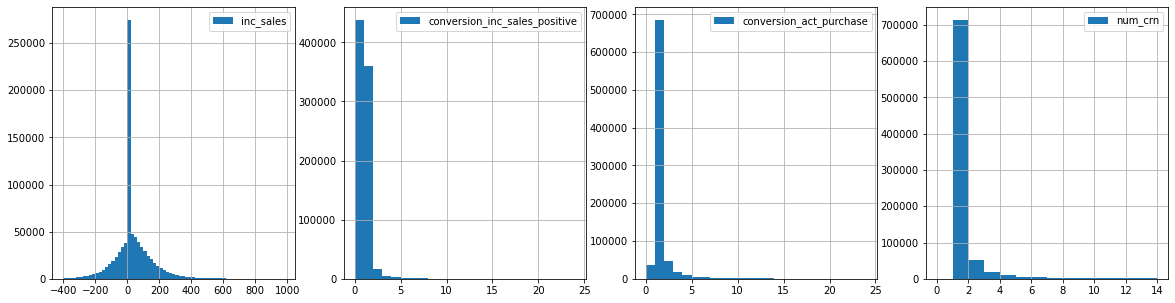

In [9]:
plt.subplot(1, 4, 1)
df.inc_sales.hist(figsize=(20,5), bins=[20 * x for x in range(-20, 50)], legend=1)
plt.subplot(1, 4, 2)
df.conversion_inc_sales_positive.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 3)
df.conversion_act_purchase.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 4)
df.num_crn.hist(figsize=(20,5), bins=[1 * x for x in range(0, 15)], legend=1)

## Running MC MTA

### Conversion := positive inc sales

In [10]:
start_time = time.time()
ca_conv_pos_inc_sales = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_inc_sales_positive',
                                       var_null='non_conversion_inc_sales_positive',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_pos_inc_sales.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_pos_inc_sales 

Number of simulations: 100000 - Reaching convergence (wait...): 10.28% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 7.85% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 6.04% > 5.00%
Number of simulations: 337500 - Convergence reached: 4.85% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (35) is reached: 99.99%
run time 44.98835206031799


channel_name  total_conversions  \
1     CAT-4003_2021-01-28_activated_purchase        8657.699763   
0             CAT-4003_2021-01-28_activation       14416.952214   
2             CAT-4003_2021-01-28_redemption        7311.992082   
94  CAT-4003_2021-01-28_unactivated_purchase       10822.124704   
11    CAT-4031_2021-02-02_activated_purchase        9495.238109   
..                                       ...                ...   
55  TBR-4103_2021-02-01_unactivated_purchase        1580.971261   
64    TBR-4303_2021-02-09_activated_purchase         941.054322   
62            TBR-4303_2021-02-09_activation         781.075087   
74            TBR-4303_2021-02-09_redemption         235.263581   
61  TBR-4303_2021-02-09_unactivated_purchase         931.643779   

    total_conversion_value  normalised_conversion_value  
1            450269.748191                     0.016599  
0            742548.146247                     0.027374  
2            389109.490487                     0.014345  
94           560430.124098                     0.020660  
11           535612.730420                     0.019745  
..                     ...                          ...  
55            95509.679967                     0.003521  
64            55307.614224                     0.002039  
62            33907.385155                     0.001250  
74            13820.696832                     0.000510  
61            49729.956890                     0.001833  

[97 rows x 4 columns]

### Conversion := activate purchase

In [11]:
start_time = time.time()
ca_conv_act_purchase = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_act_purchase',
                                       var_null='non_conversion_act_purchase',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_act_purchase.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_act_purchase 

Number of simulations: 100000 - Convergence reached: 3.14% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (35) is reached: 99.99%
run time 46.88760232925415


channel_name  total_conversions  \
1     CAT-4003_2021-01-28_activated_purchase       63990.189256   
0             CAT-4003_2021-01-28_activation       92891.963046   
2             CAT-4003_2021-01-28_redemption       42475.450300   
94  CAT-4003_2021-01-28_unactivated_purchase      129734.799285   
11    CAT-4031_2021-02-02_activated_purchase       73500.996605   
..                                       ...                ...   
55  TBR-4103_2021-02-01_unactivated_purchase       16713.166314   
64    TBR-4303_2021-02-09_activated_purchase        3324.165676   
62            TBR-4303_2021-02-09_activation        3416.503611   
74            TBR-4303_2021-02-09_redemption         554.027613   
61  TBR-4303_2021-02-09_unactivated_purchase        8956.779737   

    total_conversion_value  normalised_conversion_value  
1            525923.791409                     0.019388  
0            991677.783163                     0.036558  
2            462433.723957                     0.017048  
94           561379.161173                     0.020695  
11           431427.906625                     0.015905  
..                     ...                          ...  
55           123724.083753                     0.004561  
64            50974.016970                     0.001879  
62            33152.085843                     0.001222  
74             -702.840222                    -0.000026  
61            42819.808031                     0.001579  

[97 rows x 4 columns]

## Results

### Results - grouped by Touchpoint

In [12]:
# join act purchase definition to pos inc sales definition
results = ca_conv_pos_inc_sales.join(ca_conv_act_purchase.loc[:, ["total_conversions", "total_conversion_value", "normalised_conversion_value"]], rsuffix='_act_purchase')

# extract campaign code
campaign_code = results.channel_name.str.extract(r'([A-Z]+-[0-9]{4})(_[a-bA-B])?', False).fillna("")
campaign_code.loc[:, "campaign_code"] = campaign_code.iloc[:, 0] + campaign_code.iloc[:, 1]
results.insert(0, "campaign", campaign_code.campaign_code)

# extract campaign date
campaign_date = results.channel_name.str.extract(r'([A-Z]+-[0-9]{4}_?[a-bA-B]?_[0-9]{4}-[0-9]{2}-[0-9]{2})', False).fillna("")
campaign_date
results.insert(0, "campaign_date", campaign_date)

# rounding to clean up values
for col in ["total_conversions", "total_conversion_value", "normalised_conversion_value", "total_conversions_act_purchase",
            "total_conversion_value_act_purchase", "normalised_conversion_value_act_purchase"]:
    if col.find("normalised") > -1:
        results.loc[:, col] = (results.loc[:, col] * 100).round(4)
    else:
        results.loc[:, col] = results.loc[:, col].round(2)

results.to_csv("04_results/results_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")

pd.options.display.max_rows = 25
results.sort_values("channel_name", inplace=True)
results

campaign_date  campaign                              channel_name  \
1   CAT-4003_2021-01-28  CAT-4003    CAT-4003_2021-01-28_activated_purchase   
0   CAT-4003_2021-01-28  CAT-4003            CAT-4003_2021-01-28_activation   
2   CAT-4003_2021-01-28  CAT-4003            CAT-4003_2021-01-28_redemption   
94  CAT-4003_2021-01-28  CAT-4003  CAT-4003_2021-01-28_unactivated_purchase   
11  CAT-4031_2021-02-02  CAT-4031    CAT-4031_2021-02-02_activated_purchase   
..                  ...       ...                                       ...   
55  TBR-4103_2021-02-01  TBR-4103  TBR-4103_2021-02-01_unactivated_purchase   
64  TBR-4303_2021-02-09  TBR-4303    TBR-4303_2021-02-09_activated_purchase   
62  TBR-4303_2021-02-09  TBR-4303            TBR-4303_2021-02-09_activation   
74  TBR-4303_2021-02-09  TBR-4303            TBR-4303_2021-02-09_redemption   
61  TBR-4303_2021-02-09  TBR-4303  TBR-4303_2021-02-09_unactivated_purchase   

    total_conversions  total_conversion_value  normalised_conversion_value  \
1             8657.70               450269.75                       1.6599   
0            14416.95               742548.15                       2.7374   
2             7311.99               389109.49                       1.4345   
94           10822.12               560430.12                       2.0660   
11            9495.24               535612.73                       1.9745   
..                ...                     ...                          ...   
55            1580.97                95509.68                       0.3521   
64             941.05                55307.61                       0.2039   
62             781.08                33907.39                       0.1250   
74             235.26                13820.70                       0.0510   
61             931.64                49729.96                       0.1833   

    total_conversions_act_purchase  total_conversion_value_act_purchase  \
1                         63990.19                            525923.79   
0                         92891.96                            991677.78   
2                         42475.45                            462433.72   
94                       129734.80                            561379.16   
11                        73501.00                            431427.91   
..                             ...                                  ...   
55                        16713.17                            123724.08   
64                         3324.17                             50974.02   
62                         3416.50                             33152.09   
74                          554.03                              -702.84   
61                         8956.78                             42819.81   

    normalised_conversion_value_act_purchase  
1                                     1.9388  
0                                     3.6558  
2                                     1.7048  
94                                    2.0695  
11                                    1.5905  
..                                       ...  
55                                    0.4561  
64                                    0.1879  
62                                    0.1222  
74                                   -0.0026  
61                                    0.1579  

[97 rows x 9 columns]

### Results grouped by campaign

In [13]:
results_grouped = results.groupby(["campaign_date"]).sum()

# extract campaign code
campaign_code = pd.Series(results_grouped.index).str.extract(r'([A-Z]+-[0-9]{4})(_[a-bA-B])?', False).fillna("")
campaign_code.loc[:, "campaign_code"] = campaign_code.iloc[:, 0] + campaign_code.iloc[:, 1]

results_grouped = results_grouped.reset_index()
results_grouped.insert(0, "campaign", campaign_code.campaign_code)

# join on campaign info
results_grouped = results_grouped.merge(campaign_info.loc[:, ["cmpgn_code", "description", "cmpgn_type", "cmpgn_id"]], how='left', left_on='campaign', right_on='cmpgn_code').drop('cmpgn_code', axis=1)

pd.options.display.max_rows = 50
results_grouped

campaign          campaign_date  total_conversions  \
0     CAT-4003    CAT-4003_2021-01-28           41208.76   
1     CAT-4031    CAT-4031_2021-02-02           40493.57   
2     CAT-4105    CAT-4105_2021-02-09           50656.95   
3     CNA-0005    CNA-0005_2021-02-08           11659.66   
4     CVM-0007    CVM-0007_2021-02-01           20129.16   
5     CVM-0056    CVM-0056_2021-02-01             112.92   
6     CVM-0106    CVM-0106_2021-02-01           15320.36   
7     CVM-0108    CVM-0108_2021-01-18            8168.35   
8     CVM-0108    CVM-0108_2021-02-01            7613.13   
9     CVM-3510    CVM-3510_2021-02-01            1910.33   
10    CVM-3529    CVM-3529_2021-02-01           11782.00   
11    CVM-4076    CVM-4076_2021-02-01           27958.72   
12    ENG-3355    ENG-3355_2021-02-11           46431.62   
13  ONL-3999_B  ONL-3999_B_2021-01-14             301.13   
14    OSP-0008    OSP-0008_2021-02-03            4385.32   
15    OSP-0008    OSP-0008_2021-02-10           11574.97   
16    OSP-2373    OSP-2373_2021-02-03           48097.29   
17    OSP-2373    OSP-2373_2021-02-10           98566.03   
18    OSP-4034    OSP-4034_2021-01-27            6032.16   
19    OSP-4053    OSP-4053_2021-02-03            6417.99   
20    OSP-4054    OSP-4054_2021-02-03            5523.99   
21    OSP-4079    OSP-4079_2021-02-10           14096.99   
22    OSP-4102    OSP-4102_2021-02-10           12101.96   
23    PBU-4073    PBU-4073_2021-02-08            4347.67   
24    TBR-4103    TBR-4103_2021-02-01            6163.90   
25    TBR-4303    TBR-4303_2021-02-09            2889.03   

    total_conversion_value  normalised_conversion_value  \
0               2142357.51                       7.8978   
1               2201279.64                       8.1149   
2               2791076.23                      10.2893   
3                680339.79                       2.5081   
4               1014183.09                       3.7389   
5                  4014.10                       0.0149   
6                836896.43                       3.0851   
7                473381.02                       1.7451   
8                414976.32                       1.5298   
9                 86172.38                       0.3177   
10               612421.19                       2.2577   
11              1490207.25                       5.4938   
12              2401328.02                       8.8526   
13                13686.30                       0.0505   
14               251734.55                       0.9280   
15               648078.40                       2.3891   
16              2540007.57                       9.3638   
17              5394465.38                      19.8868   
18               300342.61                       1.1073   
19               347011.00                       1.2793   
20               304486.77                       1.1225   
21               799466.55                       2.9472   
22               671649.17                       2.4760   
23               239554.02                       0.8831   
24               313976.77                       1.1575   
25               152765.66                       0.5632   

    total_conversions_act_purchase  total_conversion_value_act_purchase  \
0                        329092.40                           2541414.45   
1                        337218.15                           1872335.19   
2                        362795.75                           2654144.90   
3                         74701.39                            902523.39   
4                        242110.07                           1238298.41   
5                          1477.41                              2486.86   
6                        134351.70                            816916.27   
7                         92060.93                            443676.95   
8                         99263.29                            435750.59   
9                         17174.85       

## Compare with Safari GT

In [14]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # grab data from GCP
    !rm -f 02_data/safari_campaign_inc_sales*.csv
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/safari_campaign_inc_sales*.csv 02_data/

Copying gs://wx-personal/AndrewLau/nash/MC_POC/safari_campaign_inc_sales000000000000.csv...
/ [1 files][  1.7 KiB/  1.7 KiB]                                                
Operation completed over 1 objects/1.7 KiB.                                      


In [15]:
safari_campaign_inc_sales = pd.read_csv("02_data/safari_campaign_inc_sales000000000000.csv")
safari_campaign_inc_sales.loc[:, "campaign_date"] = safari_campaign_inc_sales.campaign_code + "_" + safari_campaign_inc_sales.campaign_start_date
safari_campaign_inc_sales.head(10)

fw_start_date    pph campaign_code campaign_start_date  num_CRN  \
0    2021-02-08  promo      CAT-4003          2021-01-28   258989   
1    2021-02-08  promo      CAT-4031          2021-02-02    24482   
2    2021-02-08  promo      CAT-4105          2021-02-09   189316   
3    2021-02-08  promo      CNA-0005          2021-02-08    16462   
4    2021-02-08  promo      CVM-0007          2021-02-01    89451   
5    2021-02-08  promo      CVM-0056          2021-02-01      403   
6    2021-02-08  promo      CVM-0106          2021-02-01    64613   
7    2021-02-08  promo      CVM-0108          2021-01-18    35478   
8    2021-02-08  promo      CVM-0108          2021-02-01    19843   
9    2021-02-08  promo      CVM-3510          2021-02-01     9532   

      inc_sales        campaign_date  
0 -5.777302e+04  CAT-4003_2021-01-28  
1  1.921451e+05  CAT-4031_2021-02-02  
2  6.352156e+06  CAT-4105_2021-02-09  
3  6.072851e+05  CNA-0005_2021-02-08  
4  3.482327e+05  CVM-0007_2021-02-01  
5  2.696818e+04  CVM-0056_2021-02-01  
6  4.900221e+05  CVM-0106_2021-02-01  
7  6.023258e+05  CVM-0108_2021-01-18  
8  2.948687e+05  CVM-0108_2021-02-01  
9 -6.304412e+04  CVM-3510_2021-02-01

In [16]:
results_grouped_GT = results_grouped.merge(safari_campaign_inc_sales.loc[:, ["campaign_date", "pph", "num_CRN", "inc_sales"]], how='left', left_on='campaign_date', right_on='campaign_date')
results_grouped_GT.loc['Column_Total'] = results_grouped_GT.sum(numeric_only=True, axis=0)

results_grouped_GT.to_csv("04_results/results_grouped_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")
results_grouped_GT

campaign          campaign_date  total_conversions  \
0               CAT-4003    CAT-4003_2021-01-28           41208.76   
1               CAT-4031    CAT-4031_2021-02-02           40493.57   
2               CAT-4105    CAT-4105_2021-02-09           50656.95   
3               CNA-0005    CNA-0005_2021-02-08           11659.66   
4               CVM-0007    CVM-0007_2021-02-01           20129.16   
5               CVM-0056    CVM-0056_2021-02-01             112.92   
6               CVM-0106    CVM-0106_2021-02-01           15320.36   
7               CVM-0108    CVM-0108_2021-01-18            8168.35   
8               CVM-0108    CVM-0108_2021-02-01            7613.13   
9               CVM-3510    CVM-3510_2021-02-01            1910.33   
10              CVM-3529    CVM-3529_2021-02-01           11782.00   
11              CVM-4076    CVM-4076_2021-02-01           27958.72   
12              ENG-3355    ENG-3355_2021-02-11           46431.62   
13            ONL-3999_B  ONL-3999_B_2021-01-14             301.13   
14              OSP-0008    OSP-0008_2021-02-03            4385.32   
15              OSP-0008    OSP-0008_2021-02-10           11574.97   
16              OSP-2373    OSP-2373_2021-02-03           48097.29   
17              OSP-2373    OSP-2373_2021-02-10           98566.03   
18              OSP-4034    OSP-4034_2021-01-27            6032.16   
19              OSP-4053    OSP-4053_2021-02-03            6417.99   
20              OSP-4054    OSP-4054_2021-02-03            5523.99   
21              OSP-4079    OSP-4079_2021-02-10           14096.99   
22              OSP-4102    OSP-4102_2021-02-10           12101.96   
23              PBU-4073    PBU-4073_2021-02-08            4347.67   
24              TBR-4103    TBR-4103_2021-02-01            6163.90   
25              TBR-4303    TBR-4303_2021-02-09            2889.03   
Column_Total         NaN                    NaN          503943.96   

              total_conversion_value  normalised_conversion_value  \
0                         2142357.51                       7.8978   
1                         2201279.64                       8.1149   
2                         2791076.23                      10.2893   
3                          680339.79                       2.5081   
4                         1014183.09                       3.7389   
5                            4014.10                       0.0149   
6                          836896.43                       3.0851   
7                          473381.02                       1.7451   
8                          414976.32                       1.5298   
9                           86172.38                       0.3177   
10                         612421.19                       2.2577   
11                        1490207.25                       5.4938   
12                        2401328.02                       8.8526   
13                          13686.30                       0.0505   
14                         251734.55                       0.9280   
15                         648078.40                       2.3891   
16                        2540007.57                       9.3638   
17                        5394465.38                      19.8868   
18                         300342.61                       1.1073   
19                         347011.00                       1.2793   
20                         304486.77                       1.1225   
21                         799466.55                       2.9472   
22                         671649.17                       2.4760   
23                         239554.02                       0.8831   
24                         313976.77                       1.1575   
25                         152765.66                       0.5632   
Column_Total             27125857.72                     100.0000   

              total_conversions_act_purchase  \
0                                  329092.40   
1                         

In [17]:
results_for_corr = results_grouped_GT.drop("Column_Total", axis=0).set_index("campaign_date").loc[:, ["inc_sales", "total_conversion_value_act_purchase"]]
results_for_corr = results_for_corr.rename(columns={"inc_sales":"Game Theory", "total_conversion_value_act_purchase":"MC POC"})

In [18]:
print("Correlation between MC and GT output is", round(pearsonr(results_for_corr.iloc[:, 0], results_for_corr.iloc[:, 1])[0], 2))

Correlation between MC and GT output is 0.79


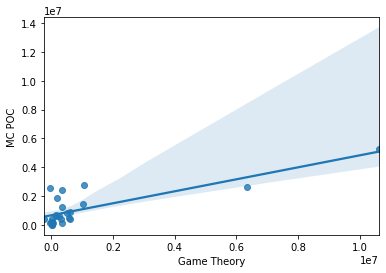

In [19]:
sns.regplot(x="Game Theory", y="MC POC", data=results_for_corr, ci=90)
plt.savefig("04_results/results_grouped_scatterplot_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".png")

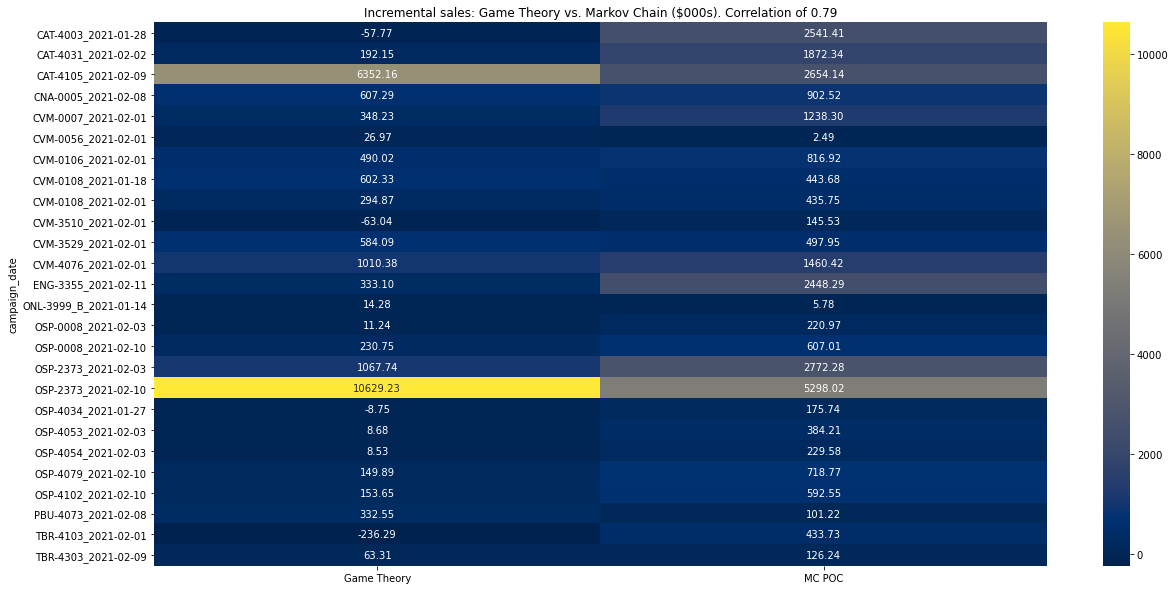

In [20]:
from matplotlib.ticker import FuncFormatter
plt.subplots(figsize=(20, 10))
plt.title("Incremental sales: Game Theory vs. Markov Chain ($000s). Correlation of "+ str(round(pearsonr(results_for_corr.iloc[:, 0], results_for_corr.iloc[:, 1])[0], 2)))

sns.heatmap(results_for_corr / 1000, cmap='cividis', annot=True, fmt=".2f")
plt.savefig("04_results/results_grouped_heatmap_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".png")